Import Library

In [1]:
!pip install geopandas

In [2]:
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


1. Find London MSOAs data 


Found existing installation: Rtree 0.9.7
Uninstalling Rtree-0.9.7:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/Rtree-0.9.7.dist-info/*
    /usr/local/lib/python3.7/dist-packages/Rtree.libs/libspatialindex-bf66e7c6.so.6.1.1
    /usr/local/lib/python3.7/dist-packages/rtree/*
Proceed (y/n)? y
  Successfully uninstalled Rtree-0.9.7
/bin/bash: brew: command not found
  Using cached Rtree-0.9.7-cp37-cp37m-manylinux2010_x86_64.whl (994 kB)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if self.run_code(code, result):


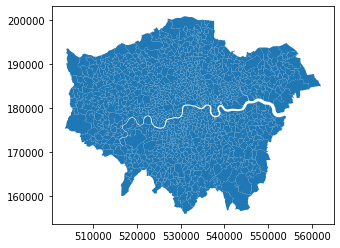

In [3]:
#Import data
msoas = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip?raw=true')
#Grab London boundary
boros = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')
ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.unary_union, crs='epsg:27700')).rename(columns={0:'original'})
# In order to ensure that we get all MSOAs _within_ London 
# we will buffer the boundary by 250m. If _cover_ were 
# easier to use then that option might be preferable.
ldn['geometry'] = ldn.original.buffer(250)
ldn = ldn.set_geometry('geometry')
#Due to the technical issue of MAC laptop, colab is used and some package needs to be manually installed.
!pip install rtree
!pip uninstall rtree
!brew install spatialindex
!pip install rtree
#Select London MSOAs using a Spatial Join
ldn_msoas = gpd.sjoin(msoas, ldn, op='within')
ldn_msoas.plot();
del(msoas)
#extract borough name
ldn_msoas['Borough'] = ldn_msoas.MSOA11NM.str.replace(r' \d+$','',regex=True)
#add msoa names
msoa_nms = pd.read_csv('https://github.com/jreades/i2p/blob/master/data/src/MSOA-Names-1.8.csv.gz?raw=true', compression='gzip')
msoas = pd.merge(ldn_msoas, msoa_nms, left_on='MSOA11CD', right_on='msoa11cd', how='inner')

Clean and save data

In [4]:
to_drop = ['MSOA11NMW','LONG','LAT','Shape__Are','Shape__Len','index_right',
           'original','msoa11cd','msoa11nm','msoa11nmw','Laname','msoa11hclnmw']
msoas.drop(columns=to_drop, inplace=True)
#save it
msoas.to_file(os.path.join('sample_data','London_MSOAs.gpkg'), driver='GPKG')

Import Airbnb data

In [5]:
#set up column names that need in future analysis
cols = ['id','name','price','latitude','longitude','accommodates','beds',]
df = pd.read_csv(os.path.join('listings.csv'), usecols=cols, low_memory=False)

df.drop(df[((df.latitude.isna())|(df.longitude.isna()))].index, axis=0, inplace=True)
df.drop(df[((df.latitude < 40)|(df.longitude > 1))].index, axis=0, inplace=True)
# Add Geometry and Reproject
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326'))
gdf = gdf.to_crs('epsg:27700')
#Associate Local Authority names to the listings using a spatial join
gdf_la = gpd.sjoin(gdf, boros, op='within', how='left')
print(gdf_la.columns.values)
#Tidy up data
gdf_la.drop(columns=['index_right','NONLD_AREA','ONS_INNER'], inplace=True)
gdf_la.NAME.unique()
#Find problematic data and drop
gdf_la.drop(index=gdf[gdf_la.NAME.isna()].index, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if self.run_code(code, result):


['id' 'name' 'latitude' 'longitude' 'accommodates' 'beds' 'price'
 'geometry' 'index_right' 'NAME' 'GSS_CODE' 'HECTARES' 'NONLD_AREA'
 'ONS_INNER']


import borough profiles data

In [6]:
cols2 = ['Code','Area_name','GLA_Population_Estimate_2017','Crime_rates_per_thousand_population_2014/15','Total_carbon_emissions_(2014)','Average_Public_Transport_Accessibility_score,_2014','Happiness_score_2011-14_(out_of_10)','Median_House_Price,_2015']
Borough_profiles = pd.read_csv('london-borough-profiles.csv', encoding= 'unicode_escape',usecols=cols2)
#Delete the rows in the end which are not boroughs names
Borough_profiles2 = Borough_profiles.drop(Borough_profiles.tail(5).index)
#rename columns
cols3 = Borough_profiles2.columns.values
cols3[ 2] = 'Population'
cols3[ 3] = 'Crime_rate'
cols3[4] = 'Carbon_emission'
cols3[5] = 'Transport_accessibility'
cols3[6] = 'Happiness_score'
cols3[7] = 'House_Price'
Borough_profiles2.columns = cols3
Borough_profiles2

,Code,Area_name,Population,Crime_rate,Carbon_emission,Transport_accessibility,Happiness_score,House_Price
0,E09000001,City of London,8800,.,799999,1036,7.9,6.0
1,E09000002,Barking and Dagenham,209000,83.4,243500,644,3,7.1
2,E09000003,Barnet,389600,62.7,445000,1415,3,7.4
3,E09000004,Bexley,244300,51.8,275000,975,2.6,7.2
4,E09000005,Brent,332100,78.8,407250,1175,3.7,7.2
5,E09000006,Bromley,327900,64.1,374975,1180,2.8,7.4
6,E09000007,Camden,242500,123.5,700000,1288,5.7,7.1
7,E09000008,Croydon,386500,77,300000,1237,3.2,7.2
8,E09000009,Ealing,351600,75.5,430000,1342,3.3,7.3
9,E09000010,Enfield,333000,69.4,320000,1245,3,7.3


Calculating for three indicators according to the model from other literature.

In [7]:
#Calculating the sum of variables that we need for borough
#Group by borough names
Abnb_data = gdf_la.groupby(['NAME'])[['accommodates','beds','HECTARES']].sum()
#Economic 1: Total arrivals of tourists per month
Abnb_data['economic_1'] = Abnb_data['accommodates']*79*0.01*30
#Social 1: ratio of tourists to local population
Abnb_data2 = Abnb_data.join(Borough_profiles2.set_index('Area_name'), on='NAME')
Abnb_data2['social_1'] = Abnb_data2['accommodates']/Abnb_data2['Population']*100
# Environmental 1: Intensity of tourists use
Abnb_data2['environmental_1'] = Abnb_data2['beds']/Abnb_data2['HECTARES']*100
Abnb_data2

,accommodates,beds,HECTARES,economic_1,Code,Population,Crime_rate,Carbon_emission,Transport_accessibility,Happiness_score,House_Price,social_1,environmental_1
NAME,,,,,,,,,,,,,
Barking and Dagenham,1103,645.0,1.474174e+06,26141.1,E09000002,209000,83.4,243500,644,3,7.1,0.527751,0.043753
Barnet,4472,2609.0,1.304695e+07,105986.4,E09000003,389600,62.7,445000,1415,3,7.4,1.147844,0.019997
Bexley,708,431.0,1.748593e+06,16779.6,E09000004,244300,51.8,275000,975,2.6,7.2,0.289808,0.024648
Brent,5877,3295.0,8.248799e+06,139284.9,E09000005,332100,78.8,407250,1175,3.7,7.2,1.769648,0.039945
Bromley,1505,904.0,8.152323e+06,35668.5,E09000006,327900,64.1,374975,1180,2.8,7.4,0.458981,0.011089
Camden,14668,7959.0,1.006449e+07,347631.6,E09000007,242500,123.5,700000,1288,5.7,7.1,6.048660,0.079080
City of London,1086,530.0,1.121194e+05,25738.2,E09000001,8800,.,799999,1036,7.9,6.0,12.340909,0.472711
Croydon,2598,1475.0,9.125160e+06,61572.6,E09000008,386500,77,300000,1237,3.2,7.2,0.672186,0.016164
Ealing,4320,2644.0,8.748224e+06,102384.0,E09000009,351600,75.5,430000,1342,3.3,7.3,1.228669,0.030223


Preparation to visualize the above resulsts.

In [8]:
#Join London Borough geometric data and Airbnb data
Airbnb_borough = Abnb_data2.merge(boros,left_on = 'Code', right_on ='GSS_CODE')
Airbnb_borough = Airbnb_borough.drop(columns=['NONLD_AREA','ONS_INNER'])

Visualize:draw three maps based on three factors results

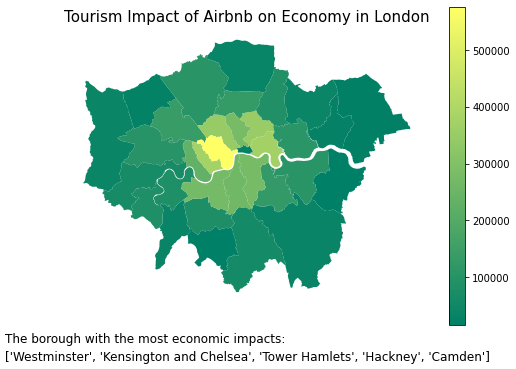

In [10]:
# Result for economic sustainability
fig, ax = plt.subplots(1,1, figsize=(15,9))
Airbnb_borough.plot(ax=ax, column='economic_1',legend=True,cmap='summer')
# check the highest borough
ranking = Abnb_data2.sort_values(by='economic_1',ascending=False)
ranking2 = ranking.iloc[0:5].loc[:,'economic_1'].index
rankinglist = []
for i in ranking2:
  rankinglist.append(i)
# remove the axis
ax.axis('off')
# add a title
ax.set_title('Tourism Impact of Airbnb on Economy in London', fontdict={'fontsize': '15', 'fontweight' : '5'})
# create an annotation for the highest borough name
ax.annotate('The borough with the most economic impacts:', xy=(0.01,0.1),xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#000000')
ax.annotate(rankinglist,xy=(0.01, 0.05), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#000000')
# this will set the image width to 722px at 100dpi
plt.tight_layout()
fig.set_size_inches(7.22, 5.25)
plt.savefig('sample_data/london_economic.png', dpi=300, alpha=True)
plt.show()

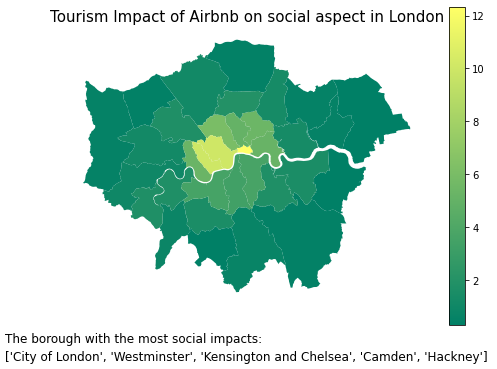

In [11]:
# Result for social sustainability
fig, ax = plt.subplots(1,1, figsize=(15,9))
Airbnb_borough.plot(ax=ax, column='social_1',legend=True,cmap='summer')
# check the highest borough
ranking = Abnb_data2.sort_values(by='social_1',ascending=False)
ranking2 = ranking.iloc[0:5].loc[:,'social_1'].index
rankinglist = []
for i in ranking2:
  rankinglist.append(i)
# remove the axis
ax.axis('off')
# add a title
ax.set_title('Tourism Impact of Airbnb on social aspect in London', fontdict={'fontsize': '15', 'fontweight' : '5'})
# create an annotation for the highest borough name
ax.annotate('The borough with the most social impacts:', xy=(0.01,0.1),xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#000000')
ax.annotate(rankinglist,xy=(0.01, 0.05), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#000000')
# this will set the image width to 722px at 100dpi
plt.tight_layout()
fig.set_size_inches(7.22, 5.25)
plt.savefig('sample_data/london_social.png', dpi=300, alpha=True)
plt.show()

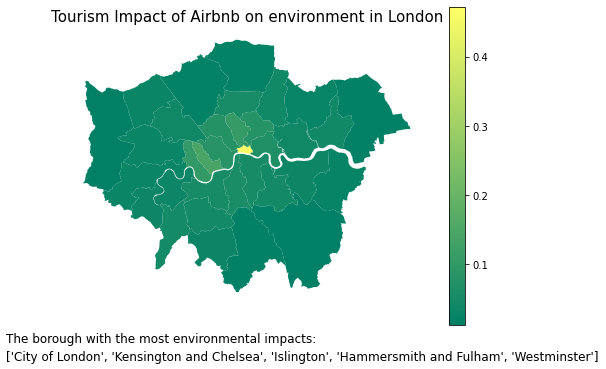

In [12]:
# Result for environmental sustainability
fig, ax = plt.subplots(1,1, figsize=(15,9))
Airbnb_borough.plot(ax=ax, column='environmental_1',legend=True,cmap='summer')
# check the highest borough
ranking = Abnb_data2.sort_values(by='environmental_1',ascending=False)
ranking2 = ranking.iloc[0:5].loc[:,'environmental_1'].index
rankinglist = []
for i in ranking2:
  rankinglist.append(i)
# remove the axis
ax.axis('off')
# add a title
ax.set_title('Tourism Impact of Airbnb on environment in London', fontdict={'fontsize': '15', 'fontweight' : '5'})
# create an annotation for the highest borough name
ax.annotate('The borough with the most environmental impacts:', xy=(0.01,0.1),xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#000000')
ax.annotate(rankinglist,xy=(0.01, 0.05), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#000000')
# this will set the image width to 722px at 100dpi
plt.tight_layout()
fig.set_size_inches(7.22, 5.25)
plt.savefig('sample_data/london_environment.png', dpi=300, alpha=True)
plt.show()

Data Preparation for conducting multiple regression model.

In [13]:
#testing VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df


to_drop_col=['accommodates','beds','HECTARES','economic_1',	'Code',	'Population','social_1','environmental_1']
Abnb_final = Abnb_data2.drop(to_drop_col,axis=1)
Abnb_final = Abnb_final.drop('City of London')
Abnb_final.info()
#Getting an error that datatype is not numeric, therefore, check and change data type.
#change datatype
def dataframe_type(df):
  for i in df:
    df[i] = df[i].astype('float')

dataframe_type(Abnb_final)
Abnb_final.info()
#Check vif
df_selected_VIF = drop_column_using_vif_(Abnb_final)
print("The columns remaining after VIF selection are:")
print(df_selected_VIF.columns)


<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 32 entries, Barking and Dagenham to Westminster
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Crime_rate               32 non-null     object 
 1   Carbon_emission          32 non-null     object 
 2   Transport_accessibility  32 non-null     object 
 3   Happiness_score          32 non-null     object 
 4   House_Price              32 non-null     float64
dtypes: float64(1), object(4)
memory usage: 1.5+ KB
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 32 entries, Barking and Dagenham to Westminster
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Crime_rate               32 non-null     float64
 1   Carbon_emission          32 non-null     float64
 2   Transport_accessibility  32 non-null     float64
 3   Happiness_score          32 n

conduct three multiple regression models

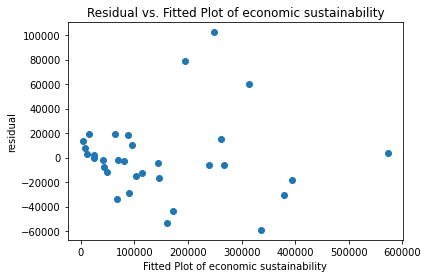

In [14]:
Abnb_data3 = Abnb_data2.drop('City of London')
Economic_regression = sm.OLS(endog=Abnb_data3[['economic_1']], exog=sm.add_constant(df_selected_VIF)).fit()

Economic_regression.summary()
# Check residuals for the model
# plot 
plt.scatter(Economic_regression.fittedvalues,Economic_regression.resid)
# adding title and labels
plt.xlabel('Fitted Plot of economic sustainability')
plt.ylabel('residual')
plt.title('Residual vs. Fitted Plot of economic sustainability')
plt.show()

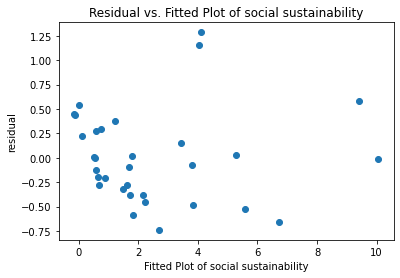

In [15]:
Social_regression = sm.OLS(endog=Abnb_data3[['social_1']], exog=sm.add_constant(df_selected_VIF)).fit()

Social_regression.summary()

# plot 
plt.scatter(Social_regression.fittedvalues,Social_regression.resid)
# adding title and labels
plt.xlabel('Fitted Plot of social sustainability')
plt.ylabel('residual')
plt.title('Residual vs. Fitted Plot of social sustainability')
plt.show()

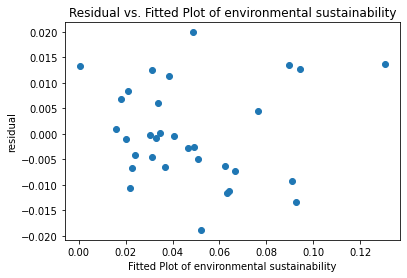

In [16]:
Environment_regression = sm.OLS(endog=Abnb_data3[['environmental_1']], exog=sm.add_constant(df_selected_VIF)).fit()

Environment_regression.summary()
# plot 
plt.scatter(Environment_regression.fittedvalues,Environment_regression.resid)
# adding title and labels
plt.xlabel('Fitted Plot of environmental sustainability')
plt.ylabel('residual')
plt.title('Residual vs. Fitted Plot of environmental sustainability')
plt.show()